In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
pip install --upgrade tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-win_amd64.whl.metadata (22 kB)
Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-win_amd64.whl (209 kB)
Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl (12.9 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninsta

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\tensorflow\\compiler\\mlir\\quantization\\tensorflow\\python\\pywrap_quantize_model.pyd'
Consider using the `--user` option or check the permissions.



In [4]:
from coinmetrics.api_client import CoinMetricsClient

client = CoinMetricsClient()

print(client)

In [47]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD  
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
# 
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')
metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2017-01-01", end_time="2024-01-02", frequency='1d')

In [48]:
metrics = pd.DataFrame(metrics)

metrics.head()

# metrics.to_csv("LSTM.csv", index=False)

df = metrics.copy()


In [49]:
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

# Target: future price (e.g., 1-day ahead)
df['PriceUSD_target'] = df['PriceUSD'].shift(-1)

df['PriceUSD_target'] = pd.to_numeric(df['PriceUSD_target'], errors='coerce')
df['PriceUSD_log'] = np.log1p(df['PriceUSD_target'])

# Add technical indicators
# Moving averages
df['MA_7'] = df['PriceUSD_target'].rolling(window=7).mean()
df['MA_30'] = df['PriceUSD_target'].rolling(window=30).mean()
df['MA_7_30_ratio'] = df['MA_7'] / df['MA_30']

# Volatility
df['Volatility_30'] = df['PriceUSD_target'].rolling(window=30).std()

 # Drop rows with NaNs from shifting
df.dropna(inplace=True)


In [50]:
# Base features
X = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD_target', 'MA_7', 'MA_30', 'MA_7_30_ratio', 'Volatility_30']].values

# X = df[['HashRate']].values
# y = df['PriceUSD_target'].values
y = df['PriceUSD'].values


In [51]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [52]:
def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Choose an appropriate sequence length (e.g., 60 days)
time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

In [53]:
# Reshape the input to be 3D [samples, time steps, features]
from sklearn.model_selection import train_test_split

# Split into train (50%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.5, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(X_train)
n_features = X_train.shape[2]
print(f"X_train shape: {X_train.shape}")

[[[3.11199173e-04 1.72608667e-01 2.46091968e-01 ... 9.35857645e-05
   4.24422152e-01 1.77559841e-03]
  [3.43250911e-04 2.46829460e-01 2.85049322e-01 ... 7.76623068e-05
   4.42503355e-01 1.62373290e-03]
  [1.84968255e-03 3.58632952e-01 3.84577226e-01 ... 6.42399083e-05
   4.60269004e-01 1.46678702e-03]
  ...
  [1.70982933e-03 2.61766079e-01 3.40398654e-01 ... 3.74304456e-03
   2.72153713e-01 6.66707114e-03]
  [1.05022053e-03 2.43065115e-01 2.76023592e-01 ... 3.66197976e-03
   2.78156942e-01 6.76893910e-03]
  [2.16443609e-03 2.32818925e-01 2.88328348e-01 ... 3.58290700e-03
   3.04316833e-01 6.63518735e-03]]

 [[3.43250911e-04 2.46829460e-01 2.85049322e-01 ... 7.76623068e-05
   4.42503355e-01 1.62373290e-03]
  [1.84968255e-03 3.58632952e-01 3.84577226e-01 ... 6.42399083e-05
   4.60269004e-01 1.46678702e-03]
  [7.27871755e-04 2.15236670e-01 2.34304289e-01 ... 0.00000000e+00
   4.83058128e-01 2.17768833e-04]
  ...
  [1.05022053e-03 2.43065115e-01 2.76023592e-01 ... 3.66197976e-03
   2.78156

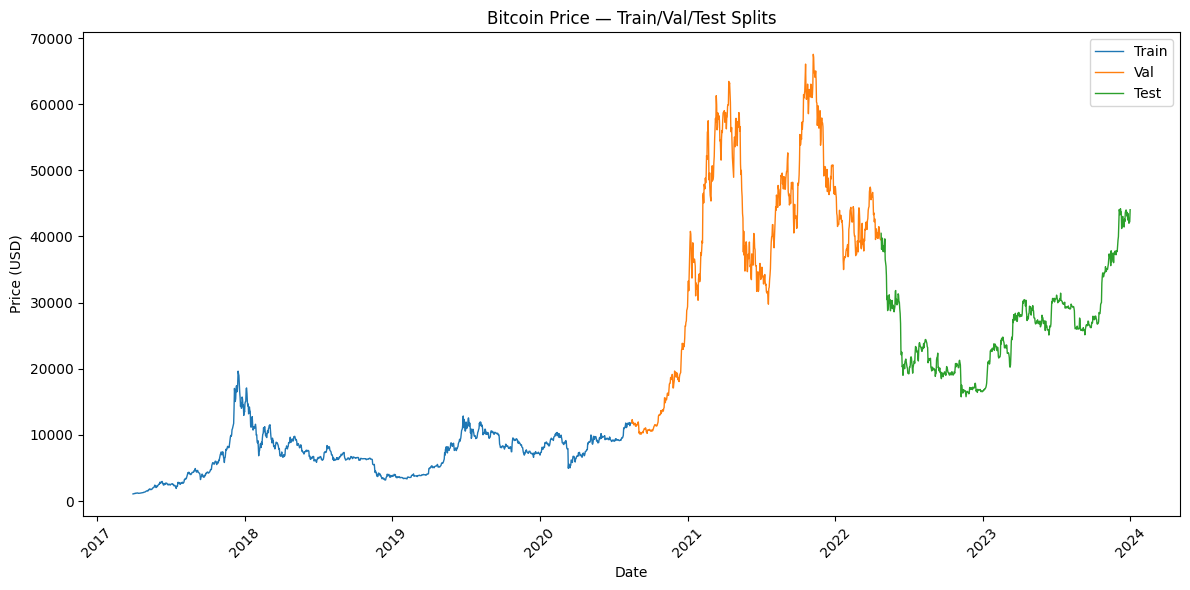

In [54]:
import matplotlib.pyplot as plt

# ---- assume you’ve just run these splits ----
# X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.5, shuffle=False)
# X_val,   X_test, y_val,   y_test   = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
# ---------------------------------------------

# Reconstruct the “date” axis for each sequence sample
# (you should still have your original df in this notebook)
dates = df['time'].iloc[time_steps:].reset_index(drop=True)

# How many samples in each split?
n_train = len(y_train)
n_val   = len(y_val)
n_test  = len(y_test)

# Slice the dates for each set
dates_train = dates[:n_train]
dates_val   = dates[n_train:n_train + n_val]
dates_test  = dates[n_train + n_val:n_train + n_val + n_test]

# Extract the actual (inverse‐scaled) prices from your scaler
y_train_actual = scaler_y.inverse_transform(y_train).flatten()
y_val_actual   = scaler_y.inverse_transform(y_val).flatten()
y_test_actual  = scaler_y.inverse_transform(y_test).flatten()

# Plot them all on one time‐series
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train_actual, label='Train',   linewidth=1)
plt.plot(dates_val,   y_val_actual,   label='Val',     linewidth=1)
plt.plot(dates_test,  y_test_actual,  label='Test',    linewidth=1)
plt.title("Bitcoin Price — Train/Val/Test Splits")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [63]:
# Building the LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.optimizers import Adam


# CNN Model
# model = Sequential()
# # First convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
#                  input_shape=(time_steps, n_features)))
# model.add(MaxPooling1D(pool_size=2))

# # Second convolutional layer
# model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# # LSTM layers follow after the CNN feature extractors
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.4))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))

# # Final dense layer for output
# model.add(Dense(1))

# BIDIRECTIONAL LSTM Model Base
# model = Sequential()
# model.add(Bidirectional(LSTM(units=50, return_sequences=True), 
#                         input_shape=(time_steps, n_features)))
# # changed dropout from 0.4 to 0.3
# model.add(Dropout(0.4))
# # changing to 100 units of neurons
# model.add(Bidirectional(LSTM(units=100))) 
# # changed dropout from 0.2 to 0.3
# # changed dropout from 0.4
# model.add(Dropout(0.4))
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# BIDIRECTIONAL LSTM Model Base Improved
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), 
                        input_shape=(time_steps, n_features)))
# changed dropout from 0.4 to 0.3
model.add(Dropout(0.4))
# changing to 100 units of neurons
model.add(Bidirectional(LSTM(units=100))) 
# changed dropout from 0.2 to 0.3
# changed dropout from 0.4
model.add(Dropout(0.4))
# model.add(Dense(256))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


# Improved Bidirectional Model with Regularization and Batch Normalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Minimal modification to your base model
# model = Sequential()
# # Layer 1, Bidirectional LSTM with Batch Normalization
# model.add(Bidirectional(LSTM(units=50, return_sequences=True),
#                         input_shape=(time_steps, n_features)))
# # model.add(BatchNormalization())  # Added Batch Normalization
# model.add(Dropout(0.3))  # Slightly reduced dropout
# # Layer 2, Bidirectional LSTM w
# model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
# # model.add(BatchNormalization())  # Added Batch Normalization
# model.add(Dropout(0.4))
# # Layer 3, Bidirectional layer with Batch Normalization
# model.add(Bidirectional(LSTM(units=40)))
# # model.add(BatchNormalization())  # Added Batch Normalization
# model.add(Dropout(0.3))

# # Layer 4, Dense layer with Batch Normalization
# model.add(Dense(units=100, activation='relu'))
# # model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # Dense Layer for output
# model.add(Dense(1, activation='linear'))  # Linear activation for regression

# # Only changed learning rate
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# Add just early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train with early stopping
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=32,  # Adjust if needed
#     validation_split=0.2,
#     callbacks=[early_stop]
# )

# # Bidirectional LSTM Model with Regularization with Recurrent Dropout
# from tensorflow.keras.regularizers import l2
# n_features = X_train.shape[2]
# model = Sequential()
# model.add(Bidirectional(
#     LSTM(50, return_sequences=True,
#          recurrent_dropout=0.1,
#          kernel_regularizer=l2(1e-4),
#          recurrent_regularizer=l2(1e-4)),
#     input_shape=(time_steps, n_features)))
# model.add(Dropout(0.3))

# model.add(Bidirectional(
#     LSTM(50,
#          recurrent_dropout=0.1,
#          kernel_regularizer=l2(1e-4),
#          recurrent_regularizer=l2(1e-4))))
# model.add(Dropout(0.2))

# model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-4)))
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# # Simple attention layer
# from tensorflow.keras.layers import Layer, Permute, Multiply, Lambda, Activation, Dense, Flatten, RepeatVector
# import tensorflow.keras.backend as K

# class Attention(Layer):
#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[-1], 1),
#                                  initializer='glorot_uniform',
#                                  trainable=True)
#         super().build(input_shape)

#     def call(self, x):
#         # x shape: (batch, timesteps, features)
#         e = K.squeeze(K.dot(x, self.W), axis=-1)           # (batch, timesteps)
#         α = K.softmax(e)                                   # attention weights
#         α = K.expand_dims(α, axis=-1)                      # (batch, timesteps, 1)
#         return K.sum(x * α, axis=1)                        # (batch, features)

# # Build with attention
# model = Sequential()
# model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_steps, n_features)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Attention())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1))
# model.compile(Adam(1e-4), 'mean_squared_error')


# LSTM Model BASE
# # Get input dimensions
# n_features = X_train.shape[2]

# # Build model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features)))
# # units = 50 is a common choice for LSTM layers, but you can experiment with this value adds 50 memory cells (neurons)
# model.add(Dropout(0.2))
# # Dropout layer to prevent overfitting, drops 20% of the neurons
# # Add another LSTM layer but returns only the last output 

# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# # -----
# model.add(Dense(units=1))
# # Predicting a single value (the next price)

# # Compile model with a slightly lower learning rate for stability
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [56]:
# import numpy as np
# from scipy.stats import cauchy
# import matplotlib.pyplot as plt

# class LSHADE:
#     """
#     Limited-memory Success-History based Adaptive Differential Evolution (L-SHADE) algorithm
    
#     L-SHADE is an advanced variant of Differential Evolution that incorporates:
#     - Success-history based parameter adaptation for F and CR
#     - Linear population size reduction
#     - Archive-based mutation strategy
#     """
    
#     def __init__(self, obj_func, dim, bounds, pop_size_init=100, max_evals=10000, 
#                  p_best_rate=0.11, arc_rate=1.4, memory_size=5):
#         """
#         Initialize the L-SHADE algorithm
        
#         Parameters:
#         -----------
#         obj_func : function
#             Objective function to be minimized
#         dim : int
#             Dimension of the problem
#         bounds : tuple of np.ndarray
#             Bounds for each dimension (lower_bounds, upper_bounds)
#         pop_size_init : int
#             Initial population size
#         max_evals : int
#             Maximum number of function evaluations
#         p_best_rate : float
#             Rate of selecting p-best individuals
#         arc_rate : float
#             Archive rate for the external archive
#         memory_size : int
#             Size of the historical memory
#         """
#         self.obj_func = obj_func
#         self.dim = dim
#         self.bounds = bounds
#         self.pop_size_init = pop_size_init
#         self.pop_size_min = 4  # Minimum population size
#         self.max_evals = max_evals
#         self.p_best_rate = p_best_rate
#         self.arc_rate = arc_rate
#         self.memory_size = memory_size
        
#         # Initialize memory for F and CR
#         self.memory_pos = 0
#         self.memory_F = np.ones(memory_size) * 0.5  # Historical F values
#         self.memory_CR = np.ones(memory_size) * 0.5  # Historical CR values
        
#         # For tracking successful parameters
#         self.success_F = []
#         self.success_CR = []
#         self.success_diffs = []
    
#     def init_population(self, pop_size):
#         """Initialize a random population within bounds"""
#         lower_bounds, upper_bounds = self.bounds
#         pop = lower_bounds + np.random.rand(pop_size, self.dim) * (upper_bounds - lower_bounds)
#         return pop
    
#     def evaluate_population(self, pop):
#         """Evaluate the population and return fitness values"""
#         return np.array([self.obj_func(ind) for ind in pop])
    
#     def select_p_best(self, pop, fitness, p_rate):
#         """Select p-best individuals from the population"""
#         p_num = max(1, int(len(pop) * p_rate))
#         idx = np.argsort(fitness)[:p_num]
#         return pop[idx]
    
#     def generate_F_CR(self, pop_size):
#         """Generate F and CR values using the current memory"""
#         # Randomly select an index from the memory
#         r_idx = np.random.randint(0, self.memory_size)
        
#         # Generate F using Cauchy distribution with location=memory_F[r_idx] and scale=0.1
#         F = cauchy.rvs(loc=self.memory_F[r_idx], scale=0.1, size=pop_size)
#         F[F <= 0] = 0.1  # Truncate negative values to small positive
#         F[F > 1] = 1.0   # Truncate values larger than 1
        
#         # Generate CR using Normal distribution with mean=memory_CR[r_idx] and std=0.1
#         CR = np.random.normal(self.memory_CR[r_idx], 0.1, size=pop_size)
#         CR = np.clip(CR, 0, 1)  # Bound CR in [0, 1]
        
#         return F, CR
    
#     def mutate(self, pop, fitness, F, archive=None):
#         """Perform current-to-pbest/1 mutation with archive"""
#         pop_size = len(pop)
#         mutants = np.zeros_like(pop)
        
#         # Combine population with archive if provided
#         if archive is not None and len(archive) > 0:
#             combined = np.vstack((pop, archive))
#         else:
#             combined = pop.copy()
        
#         # Select p-best individuals
#         p_best = self.select_p_best(pop, fitness, self.p_best_rate)
        
#         for i in range(pop_size):
#             # Randomly select a p-best individual
#             p_best_idx = np.random.randint(0, len(p_best))
            
#             # Select two distinct random individuals different from i
#             idxs = list(range(len(combined)))
#             if i < len(pop):  # Make sure we don't select i if it's in the original population
#                 idxs.remove(i)
            
#             r1, r2 = np.random.choice(idxs, 2, replace=False)
            
#             # current-to-pbest/1 mutation
#             mutants[i] = pop[i] + F[i] * (p_best[p_best_idx] - pop[i]) + F[i] * (combined[r1] - combined[r2])
        
#         return mutants
    
#     def crossover(self, pop, mutants, CR):
#         """Perform binomial crossover"""
#         pop_size, dim = pop.shape
#         trials = np.zeros_like(pop)
        
#         # Ensure at least one dimension is crossed over
#         j_rand = np.random.randint(0, dim, size=pop_size)
        
#         # Create mask for crossover
#         mask = np.random.rand(pop_size, dim) < CR[:, np.newaxis]
#         for i in range(pop_size):
#             mask[i, j_rand[i]] = True
            
#             # Apply crossover
#             trials[i] = np.where(mask[i], mutants[i], pop[i])
        
#         return trials
    
#     def bound_constrain(self, vectors):
#         """Apply bound constraints to vectors"""
#         lower_bounds, upper_bounds = self.bounds
        
#         # Replace out-of-bounds values with random values within bounds
#         out_of_bounds = (vectors < lower_bounds) | (vectors > upper_bounds)
        
#         # Where out of bounds, create random values within bounds
#         random_values = lower_bounds + np.random.rand(*vectors.shape) * (upper_bounds - lower_bounds)
        
#         # Replace only the out-of-bounds values
#         vectors = np.where(out_of_bounds, random_values, vectors)
        
#         return vectors
    
#     def update_memory(self):
#         """Update the memory of successful F and CR values"""
#         if len(self.success_F) > 0:
#             # Calculate weight using improvement values
#             diffs = np.array(self.success_diffs)
#             denom = np.sum(diffs)
            
#             if denom > 0:
#                 weights = diffs / denom
#                 # Update memory with weighted mean
#                 self.memory_F[self.memory_pos] = np.sum(weights * np.array(self.success_F))
                
#                 # Lehmer mean for CR
#                 if np.sum(np.array(self.success_CR)) > 0:  # Avoid division by zero
#                     self.memory_CR[self.memory_pos] = np.sum(weights * np.array(self.success_CR)**2) / np.sum(weights * np.array(self.success_CR))
#                 else:
#                     self.memory_CR[self.memory_pos] = 0
                
#                 # Move to the next position
#                 self.memory_pos = (self.memory_pos + 1) % self.memory_size
            
#             # Clear success history for next generation
#             self.success_F = []
#             self.success_CR = []
#             self.success_diffs = []
    
#     def get_pop_size(self, current_evals):
#         """Calculate linearly decreasing population size"""
#         t = current_evals / self.max_evals  # Normalized time
#         pop_size = round(self.pop_size_init - (self.pop_size_init - self.pop_size_min) * t)
#         return max(self.pop_size_min, pop_size)
    
#     def optimize(self, verbose=True):
#         """Main optimization loop"""
#         # Initialize counters and history
#         n_evals = 0
#         history = {'best_fitness': [], 'mean_fitness': [], 'evaluations': []}
        
#         # Initialize population
#         pop_size = self.pop_size_init
#         pop = self.init_population(pop_size)
#         fitness = self.evaluate_population(pop)
#         n_evals += pop_size
        
#         # Initialize archive
#         archive = np.empty((0, self.dim))
#         archive_max_size = int(self.arc_rate * self.pop_size_init)
        
#         # Track best solution
#         best_idx = np.argmin(fitness)
#         best_solution = pop[best_idx].copy()
#         best_fitness = fitness[best_idx]
        
#         if verbose:
#             print(f"Initial best fitness: {best_fitness}")
        
#         # Main loop
#         while n_evals < self.max_evals:
#             # Record history
#             history['best_fitness'].append(best_fitness)
#             history['mean_fitness'].append(np.mean(fitness))
#             history['evaluations'].append(n_evals)
            
#             # Generate scaling factors and crossover rates
#             F, CR = self.generate_F_CR(pop_size)
            
#             # Create mutants using current-to-pbest/1 strategy with archive
#             mutants = self.mutate(pop, fitness, F, archive)
            
#             # Apply crossover to create trial vectors
#             trials = self.crossover(pop, mutants, CR)
            
#             # Apply bound constraints
#             trials = self.bound_constrain(trials)
            
#             # Evaluate trial vectors
#             trial_fitness = self.evaluate_population(trials)
#             n_evals += pop_size
            
#             # Selection and record successful parameters
#             for i in range(pop_size):
#                 if trial_fitness[i] < fitness[i]:
#                     # Record successful parameters and improvements
#                     self.success_F.append(F[i])
#                     self.success_CR.append(CR[i])
#                     self.success_diffs.append(fitness[i] - trial_fitness[i])
                    
#                     # Add old vector to archive
#                     archive = np.vstack((archive, pop[i].reshape(1, -1)))
                    
#                     # Update population
#                     pop[i] = trials[i]
#                     fitness[i] = trial_fitness[i]
                    
#                     # Update best solution if needed
#                     if trial_fitness[i] < best_fitness:
#                         best_solution = trials[i].copy()
#                         best_fitness = trial_fitness[i]
#                         if verbose:
#                             print(f"Evals: {n_evals}, New best: {best_fitness}")
            
#             # Manage archive size
#             if len(archive) > archive_max_size:
#                 # Randomly remove excess vectors
#                 n_excess = len(archive) - archive_max_size
#                 remove_idx = np.random.choice(len(archive), n_excess, replace=False)
#                 archive = np.delete(archive, remove_idx, axis=0)
            
#             # Update memories for F and CR
#             self.update_memory()
            
#             # Update population size for next generation
#             new_pop_size = self.get_pop_size(n_evals)
            
#             # Reduce population if needed
#             if new_pop_size < pop_size:
#                 # Sort population by fitness
#                 sort_idx = np.argsort(fitness)
#                 pop = pop[sort_idx[:new_pop_size]]
#                 fitness = fitness[sort_idx[:new_pop_size]]
#                 pop_size = new_pop_size
                
#                 # Update archive max size
#                 archive_max_size = int(self.arc_rate * pop_size)
        
#         # Record final state
#         history['best_fitness'].append(best_fitness)
#         history['mean_fitness'].append(np.mean(fitness))
#         history['evaluations'].append(n_evals)
        
#         if verbose:
#             print(f"Final best fitness: {best_fitness}")
        
#         return best_solution, best_fitness, history
    
#     def plot_convergence(self, history):
#         """Plot the convergence curve"""
#         plt.figure(figsize=(10, 6))
#         plt.plot(history['evaluations'], history['best_fitness'], 'b-', linewidth=2)
#         plt.xlabel('Function Evaluations')
#         plt.ylabel('Best Fitness')
#         plt.title('L-SHADE Convergence Curve')
#         plt.grid(True)
#         plt.yscale('log')
#         plt.show()


# # Example of how to use the L-SHADE optimizer with a neural network's weights

# def optimize_nn_weights_with_lshade(model, X_train, y_train, X_val=None, y_val=None, 
#                                    pop_size=50, max_evals=5000):
#     """
#     Optimize neural network weights using L-SHADE algorithm
    
#     Parameters:
#     -----------
#     model : keras.Model
#         The neural network model to optimize
#     X_train, y_train : np.ndarray
#         Training data and targets
#     X_val, y_val : np.ndarray
#         Validation data and targets (optional)
#     pop_size : int
#         Initial population size for L-SHADE
#     max_evals : int
#         Maximum number of function evaluations
        
#     Returns:
#     --------
#     best_weights : list
#         Best weights found by L-SHADE
#     best_loss : float
#         Best loss achieved
#     history : dict
#         Optimization history
#     """
#     # Get the original model's weights
#     original_weights = model.get_weights()
    
#     # Calculate the total number of parameters
#     num_params = np.sum([w.size for w in original_weights])
#     print(f"Total parameters to optimize: {num_params}")
    
#     # Create weight shapes for reshaping the flat vector back to weights
#     weight_shapes = [w.shape for w in original_weights]
    
#     # Create flattened weights to serve as starting point
#     flat_weights = np.concatenate([w.flatten() for w in original_weights])
    
#     # Define bounds (this is an example - you might want to adjust)
#     # Using a reasonable range centered around the initial weights
#     lower_bounds = flat_weights - 1.0
#     upper_bounds = flat_weights + 1.0
#     bounds = (lower_bounds, upper_bounds)
    
#     # Define the objective function
#     def objective_function(flat_vector):
#         # Reshape the flat vector back to weights
#         weights = []
#         idx = 0
#         for shape in weight_shapes:
#             size = np.prod(shape)
#             weights.append(flat_vector[idx:idx+size].reshape(shape))
#             idx += size
        
#         # Set the weights to the model
#         model.set_weights(weights)
        
#         # Evaluate
#         if X_val is not None and y_val is not None:
#             loss = model.evaluate(X_val, y_val, verbose=0)
#         else:
#             loss = model.evaluate(X_train, y_train, verbose=0)
        
#         return loss
    
#     # Initialize L-SHADE
#     lshade = LSHADE(
#         obj_func=objective_function,
#         dim=num_params,
#         bounds=bounds,
#         pop_size_init=pop_size,
#         max_evals=max_evals
#     )
    
#     # Run optimization
#     print("Starting L-SHADE optimization...")
#     best_solution, best_loss, history = lshade.optimize(verbose=True)
    
#     # Convert best solution back to model weights
#     best_weights = []
#     idx = 0
#     for shape in weight_shapes:
#         size = np.prod(shape)
#         best_weights.append(best_solution[idx:idx+size].reshape(shape))
#         idx += size
    
#     # Plot convergence
#     lshade.plot_convergence(history)
    
#     return best_weights, best_loss, history


# # Example usage with your Keras model

# # First train the model normally to get good initial weights
# history = model.fit(
#     X_train, y_train,
#     epochs=50,  # Reduced epochs for initial training
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stop]
# )

# # Then further optimize the weights using L-SHADE
# best_weights, best_loss, optimization_history = optimize_nn_weights_with_lshade(
#     model=model,
#     X_train=X_train, 
#     y_train=y_train,
#     X_val=X_val,  # If you have separate validation data
#     y_val=y_val,
#     pop_size=30,  # Start with a moderate population size
#     max_evals=3000  # Adjust based on computational resources
#     # Max eval = 1500
# )

# # Apply the best weights found
# model.set_weights(best_weights)
# print(f"Best loss achieved with L-SHADE: {best_loss}")

# # Optional: final evaluation
# final_loss = model.evaluate(X_test, y_test, verbose=1)
# print(f"Test loss after L-SHADE optimization: {final_loss}")


In [ ]:
# # Building the LSHADE model
# # LSHADE (LSTM with SHADE) is a hyperparameter optimization algorithm that combines the principles of LSTM networks with the SHADE optimization algorithm.
# # SHADE (Success-History Adaptive Differential Evolution) is a variant of the Differential Evolution algorithm that uses historical information to adaptively adjust its parameters.
# # SHADE is particularly effective for optimizing complex, high-dimensional problems, making it suitable for hyperparameter tuning in deep learning models.
# # The LSHADE algorithm can be used to optimize the hyperparameters of LSTM networks, such as the number of LSTM units, dropout rates, learning rates, and other architectural choices.
# def build_model(hparams):
#     """
#     hparams: list or array containing hyperparameters in the following order:
#       0: conv_filters (e.g. 32 to 128)
#       1: kernel_size (e.g. 2 to 5)
#       2: lstm_units (e.g. 50 to 150)
#       3: dropout_rate (e.g. 0.1 to 0.5)
#       4: learning_rate (e.g. 1e-4 to 1e-3)
#     """
#     from tensorflow.keras.models import Sequential
#     from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
#     from tensorflow.keras.optimizers import Adam

#     conv_filters = int(hparams[0])
#     kernel_size = int(hparams[1])
#     lstm_units = int(hparams[2])
#     dropout_rate = hparams[3]
#     learning_rate = hparams[4]

#     model = Sequential()
#     # First convolutional layer
#     model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu',
#                      input_shape=(time_steps, n_features)))
#     model.add(MaxPooling1D(pool_size=2))

#     # Second convolutional layer (for illustration, we increase filters)
#     model.add(Conv1D(filters=conv_filters * 2, kernel_size=kernel_size, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))

#     # LSTM layers follow after the CNN feature extractors
#     model.add(LSTM(units=lstm_units, return_sequences=True))
#     model.add(Dropout(dropout_rate))
#     model.add(LSTM(units=lstm_units))
#     model.add(Dropout(dropout_rate))

#     # Final dense layer for output
#     model.add(Dense(1))

#     # Compile the model with a specified learning rate
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
#     return model


In [60]:
# def fitness_function(hparams):
#     import numpy as np
    
#     # Build the model with the given hyperparameters
#     model = build_model(hparams)
    
#     # Train the model for a small number of epochs to get an estimate of performance.
#     # You might want to use early stopping or even average over multiple runs.
#     history = model.fit(
#         X_train, y_train,
#         epochs=10,  # keep it small for faster evaluation
#         batch_size=32,
#         validation_data=(X_val, y_val),
#         verbose=0  # hide training output
#     )
    
#     # Return the last validation loss as the fitness score.
#     # Lower values indicate better performance.
#     val_loss = history.history['val_loss'][-1]
#     return val_loss

# Train the model with a validation split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model

    # Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
39/39 [==============================] - 11s 110ms/step - loss: 0.0033 - val_loss: 0.0852
Epoch 2/100
39/39 [==============================] - 3s 75ms/step - loss: 7.4674e-04 - val_loss: 0.0640
Epoch 3/100
39/39 [==============================] - 4s 91ms/step - loss: 4.7256e-04 - val_loss: 0.0479
Epoch 4/100
39/39 [==============================] - 3s 88ms/step - loss: 3.7784e-04 - val_loss: 0.0472
Epoch 5/100
39/39 [==============================] - 3s 90ms/step - loss: 3.4022e-04 - val_loss: 0.0538
Epoch 6/100
39/39 [==============================] - 4s 96ms/step - loss: 2.8775e-04 - val_loss: 0.0549
Epoch 7/100
39/39 [==============================] - 4s 98ms/step - loss: 2.7422e-04 - val_loss: 0.0500
Epoch 8/100
39/39 [==============================] - 4s 94ms/step - loss: 2.4480e-04 - val_loss: 0.0551
Epoch 9/100
39/39 [==============================] - 4s 92ms/step - loss: 2.1260e-04 - val_loss: 0.0462
Epoch 10/100
39/39 [==============================] - 4s 90ms/step

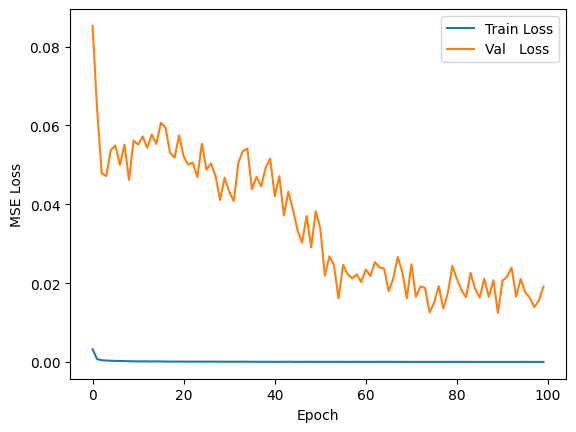

In [61]:
import matplotlib.pyplot as plt

# plt.plot(history.history['loss'],   label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.title("Training vs. Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

plt.plot(history.history['loss'],   label='Train Loss')
plt.plot(history.history['val_loss'], label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
# import numpy as np

# def l_shade(fitness_func, bounds, pop_size=20, max_gens=30):
#     """
#     fitness_func: function to evaluate candidate performance.
#     bounds: numpy array of shape (num_params, 2), with [lower_bound, upper_bound] for each parameter.
#     pop_size: initial population size.
#     max_gens: maximum number of generations.
    
#     Returns the best candidate found.
#     """
#     num_params = bounds.shape[0]
    
#     # Initialize population uniformly within bounds
#     pop = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=(pop_size, num_params))
    
#     # Evaluate fitness for each candidate
#     fitness = np.array([fitness_func(candidate) for candidate in pop])
    
#     # Placeholder for L-SHADE parameters (e.g., scaling factor, crossover probabilities)
#     # In a full implementation, these would adapt based on success history.
#     F = 0.5  # scaling factor, for example
#     CR = 0.9  # crossover probability, for example

#     for gen in range(max_gens):
#         new_pop = []
#         new_fitness = []
        
#         for i in range(pop.shape[0]):
#             # Mutation and crossover steps:
#             # - Select candidates to generate a mutant vector.
#             # - The following is a simplified DE mutation formula.
            
#             indices = list(range(pop.shape[0]))
#             indices.remove(i)
#             a, b, c = pop[np.random.choice(indices, 3, replace=False)]
#             mutant = a + F * (b - c)
#             # Ensure mutant is within the bounds
#             mutant = np.clip(mutant, bounds[:, 0], bounds[:, 1])
            
#             # Crossover: form trial vector
#             trial = pop[i].copy()
#             for j in range(num_params):
#                 if np.random.rand() < CR:
#                     trial[j] = mutant[j]
            
#             # Selection: if trial is better than current candidate, use trial
#             trial_fitness = fitness_func(trial)
#             if trial_fitness < fitness[i]:
#                 new_pop.append(trial)
#                 new_fitness.append(trial_fitness)
#             else:
#                 new_pop.append(pop[i])
#                 new_fitness.append(fitness[i])
        
#         pop = np.array(new_pop)
#         fitness = np.array(new_fitness)
        
#         # Optionally, reduce population size linearly here based on gen or update F, CR adaptively.
#         print(f"Generation {gen+1}, best fitness: {np.min(fitness)}")
    
#     # Return the candidate with the lowest fitness value
#     best_idx = np.argmin(fitness)
#     return pop[best_idx], fitness[best_idx]

# # Define bounds for each hyperparameter:
# # For [conv_filters, kernel_size, lstm_units, dropout_rate, learning_rate]
# bounds = np.array([
#     [32, 128],    # conv_filters
#     [2, 5],       # kernel_size
#     [50, 150],    # lstm_units
#     [0.1, 0.5],   # dropout_rate
#     [1e-4, 1e-3]  # learning_rate
# ])

# # Run L-SHADE optimization to find the best hyperparameters.
# best_params, best_fitness = l_shade(fitness_function, bounds, pop_size=20, max_gens=30)
# print("Best hyperparameters:", best_params)
# print("Best validation loss:", best_fitness)


Generation 1, best fitness: 0.029818639159202576


KeyboardInterrupt: 

In [105]:
# Train the model with a validation split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Add early stopping to prevent overfitting
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


# Train the model with base LSTM parameters
history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    # callbacks = [early_stop, checkpoint, reduce_lr],
    validation_data=(X_val, y_val),
)
# Rebuild the final model with optimized hyperparameters
# optimized_model = build_model(best_params)
# optimized_model.fit(
#     X_train, y_train,
#     epochs=50,  # a longer training period now that you have good hyperparameters
#     batch_size=32,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stop],
#     verbose=1
# )

# history = model.fit(X_train, y_train, epochs=70, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/70
56/56 [==============================] - 17s 97ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 2/70
56/56 [==============================] - 4s 72ms/step - loss: 6.8123e-04 - val_loss: 0.0013
Epoch 3/70
56/56 [==============================] - 4s 77ms/step - loss: 6.1400e-04 - val_loss: 0.0013
Epoch 4/70
56/56 [==============================] - 4s 81ms/step - loss: 6.0531e-04 - val_loss: 7.7287e-04
Epoch 5/70
56/56 [==============================] - 5s 97ms/step - loss: 5.9705e-04 - val_loss: 7.4771e-04
Epoch 6/70
56/56 [==============================] - 7s 115ms/step - loss: 5.5977e-04 - val_loss: 7.7430e-04
Epoch 7/70
56/56 [==============================] - 5s 81ms/step - loss: 5.6963e-04 - val_loss: 4.6393e-04
Epoch 8/70
56/56 [==============================] - 4s 77ms/step - loss: 5.5843e-04 - val_loss: 4.9991e-04
Epoch 9/70
56/56 [==============================] - 4s 81ms/step - loss: 5.5416e-04 - val_loss: 7.4556e-04
Epoch 10/70
56/56 [==============================] 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluation and make predictions
# Predict on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform to get actual price values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
# y_test_actual = scaler_y.inverse_transform(y_test)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"RMSE for testing: {rmse}")
print(f"MAE for testing: {mae}")

def directional_accuracy(y_true, y_pred):
    y_true_direction = np.sign(np.diff(y_true.flatten()))
    y_pred_direction = np.sign(np.diff(y_pred.flatten()))
    return np.mean(y_true_direction == y_pred_direction)

dir_acc = directional_accuracy(y_test_actual, y_pred)

print(f"RMSE for testing: {rmse}")
print(f"MAE for testing: {mae}")
print(f"Directional Accuracy: {dir_acc:.4f}")


20/20 [==============================] - 2s 23ms/step


ValueError: y_true and y_pred have different number of output (1!=256)

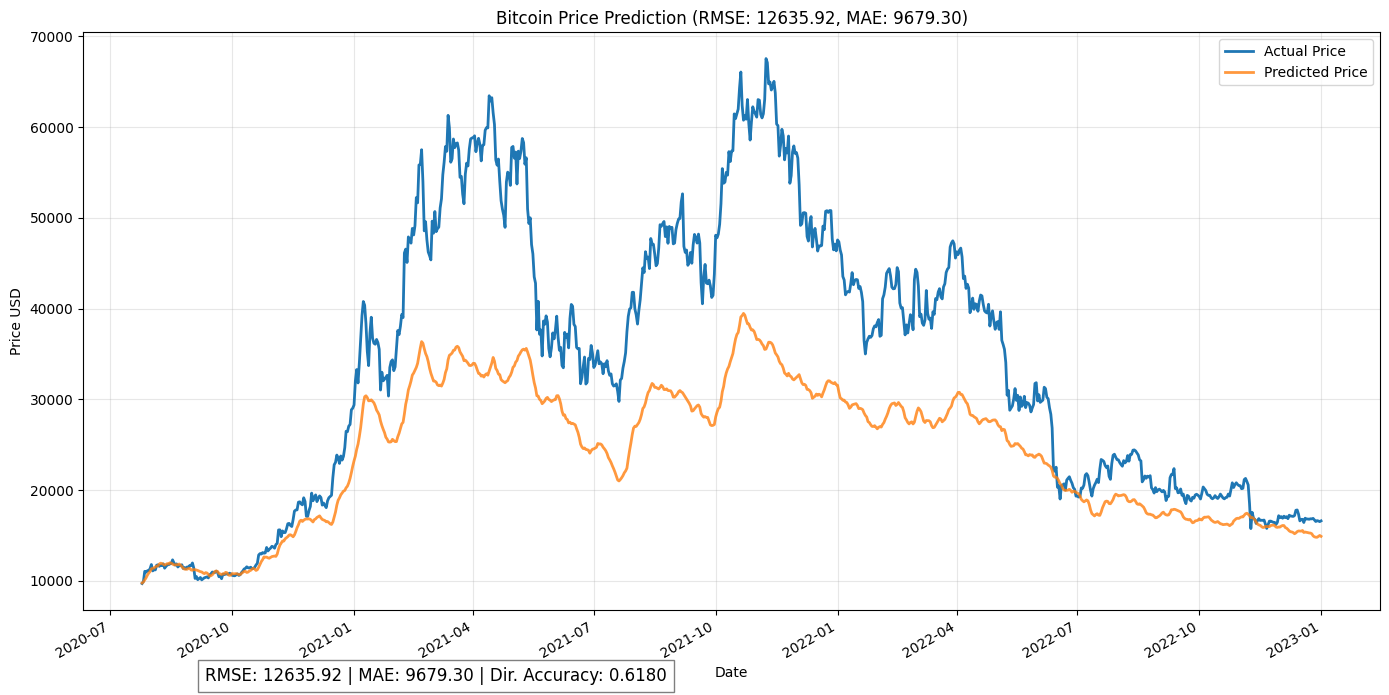

In [37]:
# # Visualizing the result
# import matplotlib.pyplot as plt

# # Visualize predictions
# plt.figure(figsize=(14, 7))
# plt.plot(y_test_actual, label='Actual Price', color='blue')
# plt.plot(y_pred, label='Predicted Price', color='red', linestyle='--')
# plt.title('Bitcoin Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Price USD')
# plt.legend()
# plt.grid(True)
# plt.show()

# After your predictions and metrics calculations:

# Get the dates for the test set
# We need to find the dates that correspond to our test set
test_dates = df['time'].iloc[-(len(y_test_actual)):]

# Visualizing the result with dates
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted Price', linewidth=2, alpha=0.8)
plt.title(f'Bitcoin Price Prediction (RMSE: {rmse:.2f}, MAE: {mae:.2f})')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(alpha=0.3)

# Format x-axis to show dates properly
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Add text annotation for metrics
plt.figtext(0.15, 0.02, f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | Dir. Accuracy: {dir_acc:.4f}", 
            ha="left", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.show()

In [22]:
# Get the last 60 days of data (make sure to use all your features)
last_60_days = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD_target', 
                  'MA_7', 'MA_30', 'MA_7_30_ratio', 'Volatility_30']].tail(time_steps).values

# Scale the data using your scaler_X
last_60_days_scaled = scaler_X.transform(last_60_days)

# Reshape for LSTM input (1 sample, 60 timesteps, n_features)
X_predict = last_60_days_scaled.reshape(1, time_steps, n_features)

# Make prediction
predicted_price_scaled = model.predict(X_predict)

# Inverse transform to get actual price
predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

print(f"Predicted Bitcoin Price: ${predicted_price[0][0]:.2f}")

# Compare with the last known price
last_actual_price = df['PriceUSD_target'].iloc[-1]
print(f"Last Known Price: ${last_actual_price:.2f}")
print(f"Predicted Change: {((predicted_price[0][0] - last_actual_price) / last_actual_price * 100):.2f}%")

1/1 [==============================] - 0s 84ms/step
Predicted Bitcoin Price: $16560.02
Last Known Price: $16688.72
Predicted Change: -0.77%


In [23]:
# Function to predict multiple days ahead
def predict_future(days_ahead=7):
    # Start with the last known sequence
    current_sequence = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD_target', 
                          'MA_7', 'MA_30', 'MA_7_30_ratio', 'Volatility_30']].tail(time_steps).values
    current_sequence_scaled = scaler_X.transform(current_sequence)
    
    predictions = []
    
    for _ in range(days_ahead):
        # Reshape for prediction
        X_pred = current_sequence_scaled.reshape(1, time_steps, n_features)
        
        # Predict next price
        next_price_scaled = model.predict(X_pred, verbose=0)
        next_price = scaler_y.inverse_transform(next_price_scaled)[0][0]
        predictions.append(next_price)
        
        # Update sequence by adding the new prediction
        # This is a simplified approach - in reality you'd need to estimate other features too
        new_row = current_sequence[-1].copy()
        new_row[4] = scaler_y.inverse_transform(next_price_scaled)[0][0]  # Update PriceUSD_target
        new_row = np.array([new_row])
        new_row_scaled = scaler_X.transform(new_row)
        
        # Remove oldest day and add newest prediction
        current_sequence_scaled = np.vstack([current_sequence_scaled[1:], new_row_scaled])
    
    return predictions

# Predict prices for the next 7 days
future_prices = predict_future(7)
print("Predicted prices for the next 7 days:")
for i, price in enumerate(future_prices):
    print(f"Day {i+1}: ${price:.2f}")

Predicted prices for the next 7 days:
Day 1: $16560.02
Day 2: $16196.39
Day 3: $16025.96
Day 4: $15782.09
Day 5: $15614.76
Day 6: $15424.86
Day 7: $15175.82


In [24]:
# # Install the missing dependency
# %pip install tabulate

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Metric': ['Total Data Points', 'Training Data Points', 'Testing Data Points',
               'RMSE', 'MAE', 'Directional Accuracy',
               'First Actual Price', 'First Predicted Price',
               'Last Actual Price', 'Last Predicted Price', 'Predicted Future Price'],
    'Value': [len(df), len(X_train), len(X_test),
              rmse, mae, dir_acc,
              y_test_actual[0][0], y_pred[0][0],
              y_test_actual[-1][0], y_pred[-1][0], predicted_price[0][0]]
})

# Display in markdown format
print(results_df.to_markdown(index=False))

| Metric                 |        Value |
|:-----------------------|-------------:|
| Total Data Points      |  3624        |
| Training Data Points   |  1782        |
| Testing Data Points    |   891        |
| RMSE                   | 10210.2      |
| MAE                    |  7489.94     |
| Directional Accuracy   |     0.623596 |
| First Actual Price     |  9702.45     |
| First Predicted Price  |  9429.3      |
| Last Actual Price      | 16606.8      |
| Last Predicted Price   | 16765.5      |
| Predicted Future Price | 16560        |


Predicted Bitcoin Price: $16560.02
Last Known Price: $16688.72
Predicted Change: -0.77%


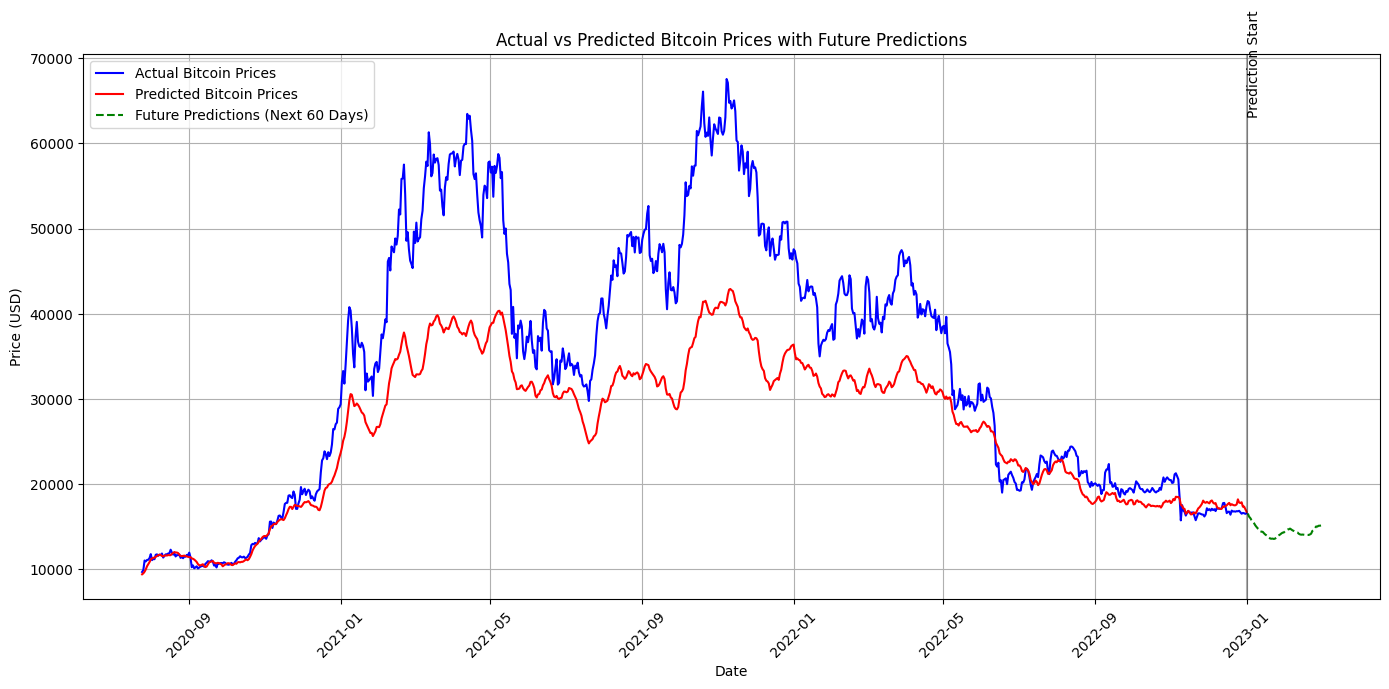

In [25]:
# First, we need to generate future dates
last_date = df['time'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')

# Get future predictions (using the function from earlier)
future_predictions = predict_future(days_ahead=60)

# Plotting future predictions alongside actual prices
plt.figure(figsize=(14, 7))

# Get the actual dates for the test set
test_dates = df['time'].iloc[-len(y_test_actual):]

# Plot actual prices with dates
plt.plot(test_dates, y_test_actual, label='Actual Bitcoin Prices', color='blue')

# Plot predicted prices for test period
plt.plot(test_dates, y_pred, label='Predicted Bitcoin Prices', color='red')

# Future Predictions
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 60 Days)', 
         color='green', linestyle='--')

predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

print(f"Predicted Bitcoin Price: ${predicted_price[0][0]:.2f}")

# Compare with the last known price
last_actual_price = df['PriceUSD_target'].iloc[-1]
print(f"Last Known Price: ${last_actual_price:.2f}")
print(f"Predicted Change: {((predicted_price[0][0] - last_actual_price) / last_actual_price * 100):.2f}%")

# Add a vertical line to mark where predictions start
plt.axvline(x=last_date, color='black', linestyle='-', alpha=0.3)
plt.text(last_date, plt.ylim()[1]*0.9, 'Prediction Start', rotation=90)

# Plotting
plt.title('Actual vs Predicted Bitcoin Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

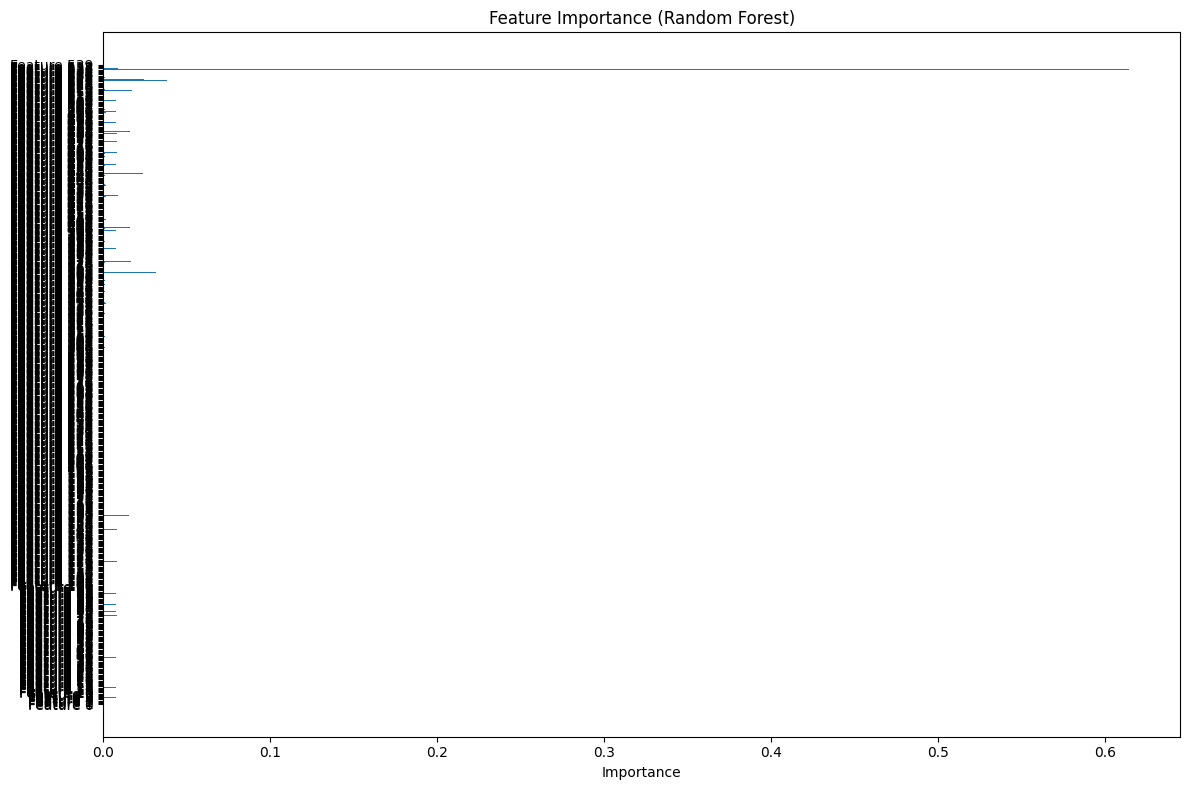

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Flatten the sequences for random forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train.ravel())

# Get feature importances
importances = rf.feature_importances_
feature_names = [f'Feature {i}' for i in range(X_train_flat.shape[1])]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), feature_names)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()